# 0. IMPORTS

## 0.1. Python Libraries

In [42]:
# Essencial libraries
import math
import pickle
import random
import datetime
import inflection
import pandas     as pd
import numpy      as np

# Graph plots
import seaborn           as     sns
import scikitplot        as     skplt
import plotly.express    as     px
from   matplotlib.artist import Artist 
from   matplotlib        import pyplot as plt

# Features selections
from boruta import BorutaPy

# stylish preferences
sns.set_style('darkgrid')

## 0.2. Helper Functions

## 0.3. Loading the [Dataset](https://www.kaggle.com/competitions/rossmann-store-sales/data?select=train.csv)

In [22]:
train_raw = pd.read_csv('C:/Users/Guilherme/Documents/repos/rossman_forecast_sales/dataset/train.csv', low_memory=False)
store_raw = pd.read_csv('C:/Users/Guilherme/Documents/repos/rossman_forecast_sales/dataset/store.csv', low_memory=False)

df_raw = pd.merge(train_raw, store_raw, how = 'left', on='Store')

# 1. DATA UNDERSTANDING

Initial contact with the dataset.

In [23]:
df1 = df_raw.copy()

In [24]:
cols_snake = list( map( lambda x: inflection.underscore( x ), df1.columns ) )
df1.columns = cols_snake

## 1.1. Data Preview

- **store** - a unique Id for each store
- **sales** - the turnover for any given day (this is what you are predicting)
- **customers** - the number of customers on a given day
- **open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **state_holiday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **school_holiday** - indicates if the (Store, Date) was affected by the closure of public schools
- **store_type** - differentiates between 4 different store models: a, b, c, d
- **assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **competition_distance** - distance in meters to the nearest competitor store
- **competition_open_since[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **promo** - indicates whether a store is running a promo on that day
- **promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **promo2_since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **promo_interval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [25]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Data Format and Type

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

`date` data type needs to be covented to `datetime64` format.

In [27]:
df1['date'] = pd.to_datetime( df1['date'] )

In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.3. Check NA

In [29]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.3.1. Treatment NA

In [30]:
# competition_distance - if there ins't competition nearby, is reasonable to assume competition_distance is a large number
max_distance = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: (5*max_distance) if math.isnan(x) else x)

# competition_open_since_month - if there is no competitor nearby or we don't know when it opened, we assume the date of the last sell
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                                          else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                                        else x['competition_open_since_year'], axis=1)

# promo2_since_week           
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                             else x['promo2_since_week'], axis=1)

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                             else x['promo2_since_year'], axis=1)

# promo_interval              
df1['promo_interval'].fillna(0, inplace=True)


In [31]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.4. Changing Data Types

In [32]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [33]:
# Changing from float64 to int64
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
    
df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 ) 
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )



In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 1.5. Data Descriptive

In [35]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1.  Numerical Data

In [37]:
np.round( num_attributes.describe(),2 ).T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,6401.14,20529.90,20.0,710.0,2330.0,6910.0,379300.0
competition_open_since_month,1017209.0,6.79,3.31,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.32,5.52,1900.0,2008.0,2012.0,2014.0,2015.0


In [38]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max()-x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,379300.0,379280.0,6401.139107,2330.0,20529.887501,15.699494,280.001870
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.5.2. Categorical Data 

In [39]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

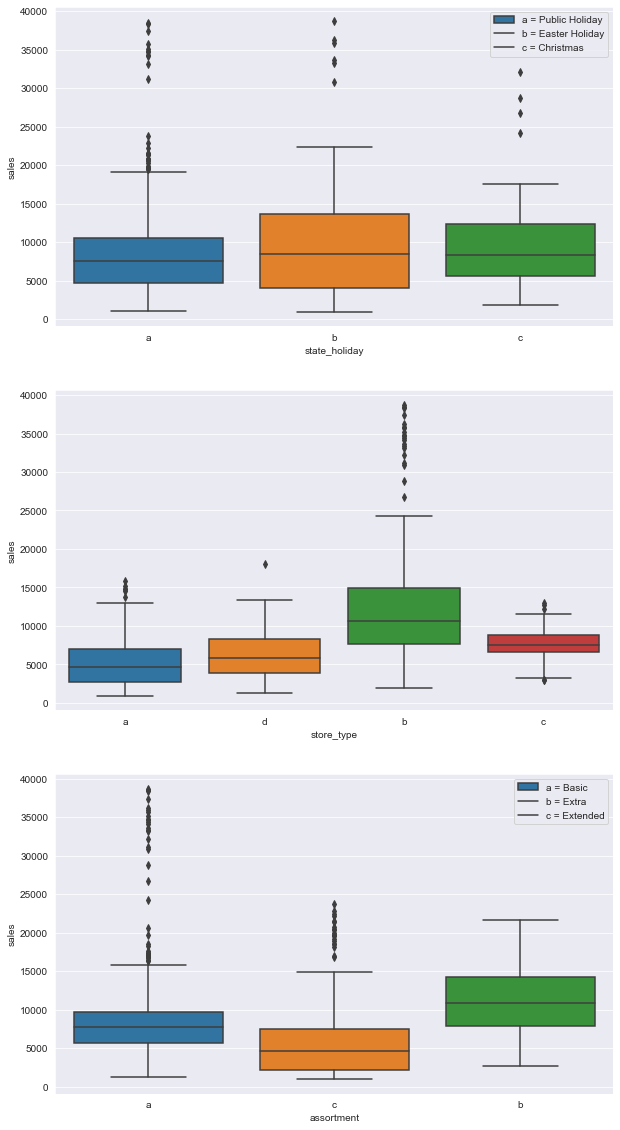

In [77]:
# Filtering the days the stores will be open
store_open = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 ) ]

plt.figure(figsize=(10,20))
plt.subplot( 3, 1 ,1 )
sns.boxplot( x='state_holiday', y='sales', data=store_open )
plt.legend(labels=['a = Public Holiday', 'b = Easter Holiday', 'c = Christmas'], 
           loc='upper right')

plt.subplot( 3, 1 ,2 )
sns.boxplot( x='store_type', y='sales', data=store_open )

plt.subplot( 3, 1 ,3 )
sns.boxplot( x='assortment', y='sales', data=store_open )
plt.legend(labels=['a = Basic', 'b = Extra', 'c = Extended'], 
           loc='upper right');

## 1.6. Saving the Dataset

In [78]:
df1.to_csv('C:/Users/Guilherme/Documents/repos/rossman_forecast_sales/dataset/df1.csv', index=False)

# 2. FEATURE ENGINEERING

Feature engineering refers to manipulation ( addition, deletion, combination, mutation ) of your data set to improve machine learning model training, leading to better performance and greater accuracy.

In [81]:
df2 = pd.read_csv('C:/Users/Guilherme/Documents/repos/rossman_forecast_sales/dataset/df1.csv', low_memory=False)
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0


## 2.1. Day of Week

## 2.2. Year

## 2.3. Month

## 2.4. Year Week

## 2.5. Year Month

## 2.6. Week of Year

## 2.7. Competition Since

### 2.7.1. Competition Time Month 

## 2.8. Promo Since

### 2.8.1. Promo Time Week 

## 2.9. Assortment

## 2.10. State Holiday

# 3. DATA FILTERING

Data filtering, as the name implies, has the purpose of adding filter to better analyze your data. When data is filtered, only rows that meet the filter criteria will display and other rows will be hidden.

I conclude that the data doesn't needed to be filtered.

## 3.1. FIltering Lines 

## 3.2. Columns Selection 

# 4. EDA ( Exploratory Data Analysis )

EDA is applied to investigate the data and summarize the key insights. It will give you the basic understanding of your data, it's distribution, null values and much more. You can either explore data using graphs or through some python functions.

From this study, I'll draw conclusion on the data.

# 5. HYPOTHESES

# 6. DATA PREPARATION | DATA PREPROCESSING 

[Data preparation allows for efficient data analysis, limits errors and inaccuracies that can occur during data processing, and makes all processed data more accessible to users](https://www.talend.com/resources/what-is-data-preparation/)
### [The five D's of data preparation](https://www.sas.com/en_us/insights/articles/data-management/the-five-d-s-of-data-preparation.html)

1. Discover
2. Detain
3. Distil
4. Document
5. Deiver

# 7. FEATURE SELECTION

[Feature Selection](https://www.simplilearn.com/tutorials/machine-learning-tutorial/feature-selection-in-machine-learning) is the method of reducing the input variable to your model by using only relevant data and getting rid of noise in data. 

It is the process of automatically choosing relevant features for your machine learning model, based on the type of problem you are trying to solve

# 8. MACHINE LEARNING

# 9. CROSS VALIDATION AND MODELS PERFORMANCE

# 10. xxxxx HYPERPARAMENTER TUNING

# zzz. Future Work